# 03 信号処理の基礎
## データを加工・分析する

このノートブックでは、読み込んだデータを**フィルタリング**や**周波数分析**などの基本的な信号処理テクニックで加工・分析する方法を紹介します。

**学習目標:**
- FFTによる周波数領域変換
- ローパス/ハイパス/バンドパスフィルタ
- スペクトル分析と可視化
- フィルタ設計の基礎

**前提条件:**
- 02_working_with_data.ipynb を完了していること

## 🎯 なぜ信号処理が必要か

### 現実世界の信号は「汚い」

**生データ**にはさまざまな問題があります：

1. **ノイズ**: 測定誤差や環境ノイズ
2. **不要な周波数成分**: 分析対象外の信号
3. **オフセット/ドリフト**: センサーのゼロ点ずれ
4. **歪み**: 非線形特性による歪み

### 信号処理で何ができるか

- **ノイズ除去**: フィルタリングで不要な成分を除去
- **特徴抽出**: 周波数分析で信号の特性を理解
- **信号改善**: 強調したい成分を強調
- **データ圧縮**: 重要な情報のみを保持

### Wandasの信号処理特徴

- **メソッドチェーン**: 直感的な処理パイプライン
- **自動パラメータ**: サンプリングレートに基づく最適設定
- **リアルタイム処理**: ストリーミングデータ対応
- **品質保証**: 処理履歴の完全追跡

## 🔄 時間領域 vs 周波数領域

### 二つの視点で信号を見る

**時間領域**（Time Domain）:
- **何時**に**どのくらい**の値か
- 直感的でわかりやすい
- 波形の形状、振幅、持続時間を直接見れる

**周波数領域**（Frequency Domain）:
- **どの周波数**が**どのくらい**含まれているか
- 信号の「成分」を分析できる
- フィルタリングの設計に不可欠

### FFT（高速フーリエ変換）の役割

FFTは**時間領域 ↔ 周波数領域**の変換を行うアルゴリズム：
- **計算効率**: O(N log N) の高速処理
- **可逆性**: 逆FFTで元の信号に戻せる
- **周波数分解能**: サンプル数で決まる
- **リアルタイム性**: 連続処理が可能

In [1]:
# 必要なライブラリをインポート
import wandas as wd
import numpy as np
import matplotlib.pyplot as plt

# インタラクティブプロット設定
%matplotlib widget
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Wandas: {wd.__version__}")
print("✅ 準備完了")

Wandas: 0.1.7
✅ 準備完了


In [2]:
# デモ用の信号を作成
np.random.seed(42)
sampling_rate = 1000  # 1kHz
duration = 2.0
time = np.linspace(0, duration, int(duration * sampling_rate))

# 複数の周波数成分を持つ信号
signal = (
    1.0 * np.sin(2 * np.pi * 50 * time) +   # 50Hz
    0.7 * np.sin(2 * np.pi * 120 * time) +  # 120Hz
    0.5 * np.sin(2 * np.pi * 200 * time) +  # 200Hz
    0.1 * np.random.randn(len(time))       # ノイズ
)

# ChannelFrameを作成
demo_signal = wd.from_numpy(
    data=signal.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Demo Signal']
)

print(f"デモ信号作成完了:")
demo_signal.info()

デモ信号作成完了:
ChannelFrame Information:
  Channels: 1
  Sampling rate: 1000 Hz
  Duration: 2.0 s
  Samples: 2000
  Channel labels: ['Demo Signal']
  Operations Applied: None


## 📊 FFTによる周波数分析

### 時間領域での観察

まずは**時間領域**で信号を見てみましょう。

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


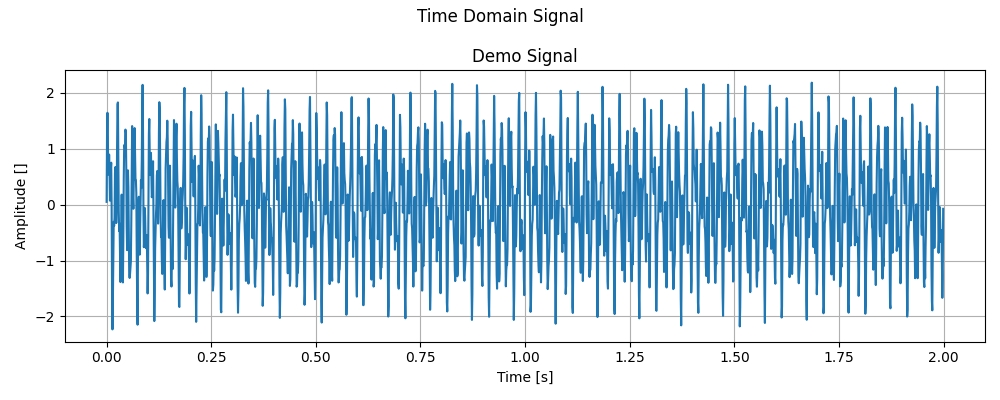

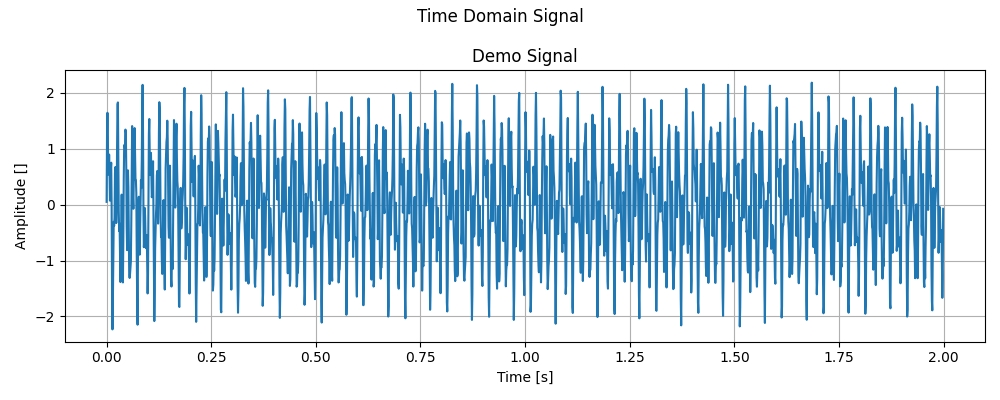

In [3]:
# 時間領域での波形表示
demo_signal.plot(title="Time Domain Signal")
plt.show()

### 周波数領域への変換

同じ信号を**周波数領域**で観察してみましょう。

🔄 FFT変換結果:
SpectralFrame Information:
  Channels: 1
  Sampling rate: 1000 Hz
  FFT size: 2001
  Frequency range: 0.0 - 499.8 Hz
  Frequency bins: 1001
  Frequency resolution (ΔF): 0.5 Hz
  Channel labels: ['Demo Signal']
  Operations Applied: 1


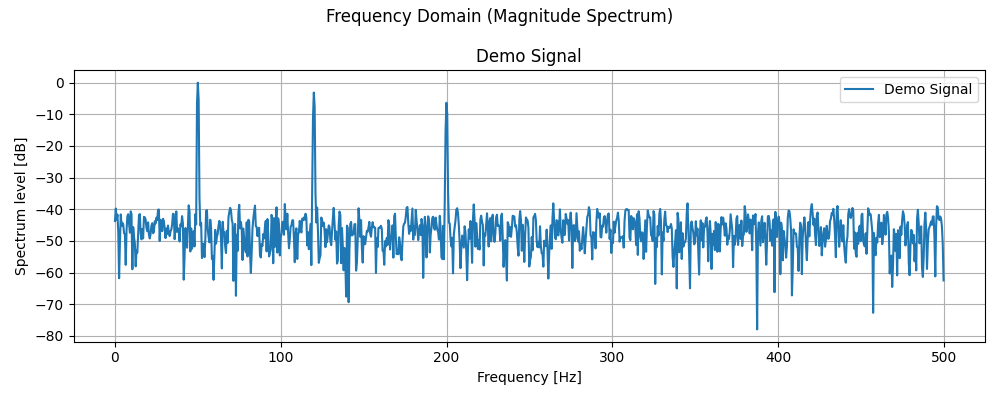

In [4]:
# FFTを実行
spectrum = demo_signal.fft()

print("🔄 FFT変換結果:")
spectrum.info()

# スペクトルをプロット
spectrum.plot(title="Frequency Domain (Magnitude Spectrum)")

**🎯 スペクトル分析のポイント**

- **50Hz, 120Hz, 200Hz**のピークが見える
- **ノイズ**は全周波数帯に広がっている
- **振幅**は元の信号の強さを表す

### 位相スペクトルも見てみましょう

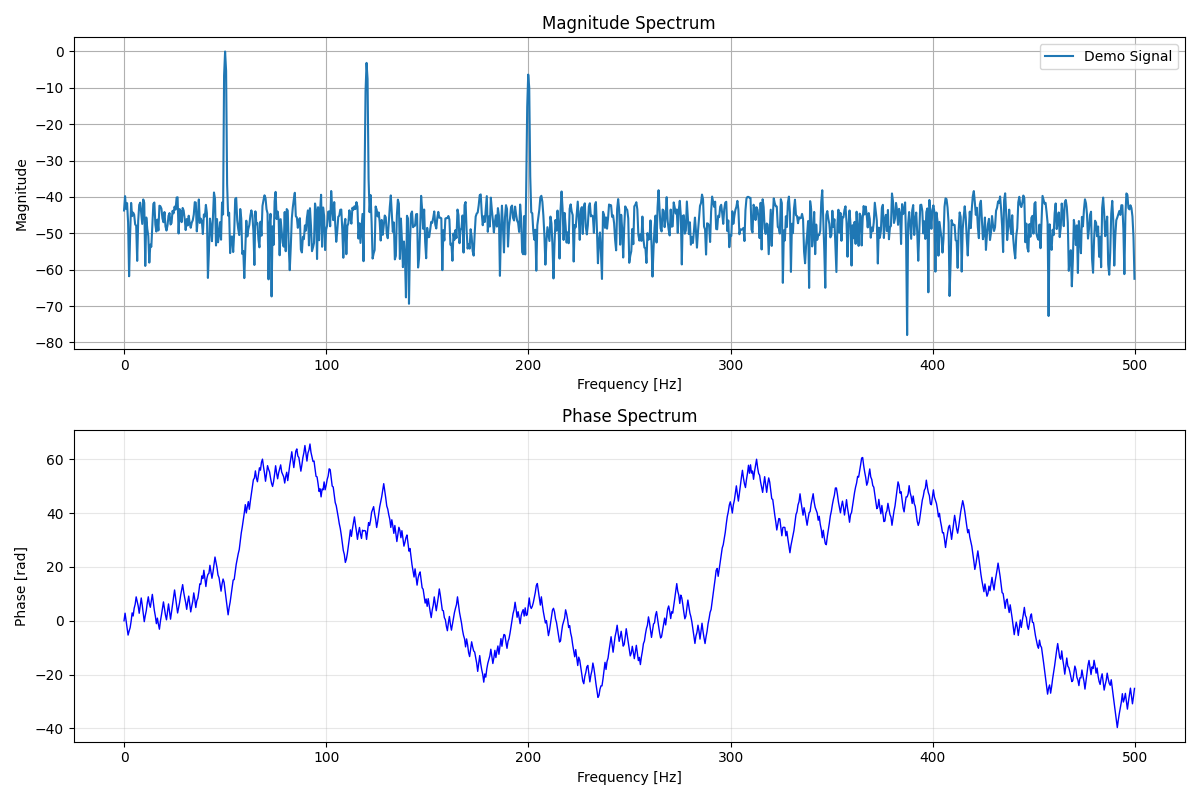

In [5]:
# 位相スペクトルも表示
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 振幅スペクトル
spectrum.plot(ax=ax1, title="Magnitude Spectrum", ylabel="Magnitude")

# 位相スペクトル
ax2.plot(spectrum.freqs, spectrum.unwrapped_phase, 'b-', linewidth=1)
ax2.set_title("Phase Spectrum")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Phase [rad]")
ax2.grid(True, alpha=0.3)

plt.tight_layout()

### Welch法によるパワースペクトル密度推定

**Welch法**は、信号をオーバーラップするセグメントに分割し、各セグメントのパワースペクトルを平均化することで、より滑らかで信頼性の高いパワースペクトル密度（PSD）を得る方法です。

**FFT vs Welch法の違い:**
- **FFT**: 単一のスペクトル（周波数分解能が高いが変動が大きい）
- **Welch法**: 平均化されたPSD（滑らかだが周波数分解能が低い）

**Welch法の利点:**
- **分散の低減**: 平均化によりノイズの影響を軽減
- **スペクトルの平滑化**: より安定した推定結果
- **ノイズ成分の識別**: ランダムノイズと信号成分を区別しやすい

🔄 Welch法によるスペクトル:
SpectralFrame Information:
  Channels: 1
  Sampling rate: 1000 Hz
  FFT size: 2048
  Frequency range: 0.0 - 500.0 Hz
  Frequency bins: 1025
  Frequency resolution (ΔF): 0.5 Hz
  Channel labels: ['Demo Signal']
  Operations Applied: 1


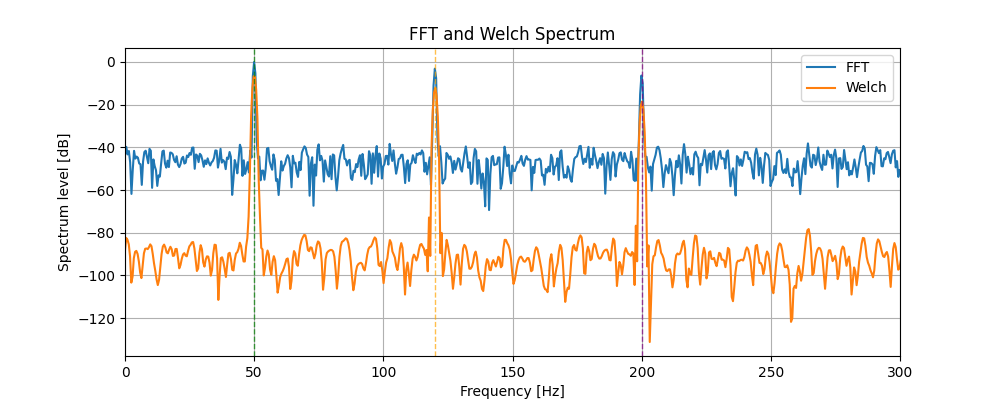

In [6]:
# Welch法によるパワースペクトル推定
# demo_signal.welch()メソッドを使用
welch_result = demo_signal.welch(
    win_length=1024,   # セグメント長
    hop_length=512,    # ホップサイズ（50%オーバーラップ）
    n_fft=2048         # FFTサイズ
)

print("🔄 Welch法によるスペクトル:")
welch_result.info()
# FFTスペクトルとWelchスペクトルを比較
# FFTスペクトル
ax = spectrum[0].plot(overlay=True)
# Welchスペクトル
welch_result[0].plot(ax=ax, title="FFT and Welch Spectrum", xlim=(0, 300), overlay=True)
ax.legend(("FFT","Welch"))
# 主要なピークをマーク

ax.axvline(50, color='green', linestyle='--', alpha=0.7, linewidth=1, label='50Hz')
ax.axvline(120, color='orange', linestyle='--', alpha=0.7, linewidth=1, label='120Hz')
ax.axvline(200, color='purple', linestyle='--', alpha=0.7, linewidth=1, label='200Hz')


**📊 Welch法の特徴と利点**

- **滑らかなスペクトル**: 平均化によりノイズの影響が軽減され、安定した推定結果が得られる
- **パワースペクトル**: 周波数帯域あたりのパワーを表す
- **50Hz, 120Hz, 200Hz**のピークがより明確に識別できる
- **ノイズ床**: ノイズレベルが安定して推定される

### FFT vs Welch法の比較

**FFTパワースペクトル:**
- ✅ 高い周波数分解能
- ❌ ノイズの影響で変動が大きい
- 📈 単一の時間窓での計算

**Welch PSD:**
- ✅ 安定した推定値（平均化による）
- ✅ ノイズと信号成分を区別しやすい
- ❌ 周波数分解能が低い
- 📈 複数セグメントの平均

### Welch法のパラメータ調整

Welch法のパラメータによって結果が大きく変わります：

- **`nperseg`**: セグメント長（大きいほど周波数分解能が高いが、時間分解能が低い）
- **`noverlap`**: オーバーラップ長（50-75%が一般的）
- **`nfft`**: FFTサイズ（nperseg以上にする）

**パラメータのトレードオフ:**
- **高周波数分解能**: npersegを大きく
- **高安定性**: noverlapを大きく（より多くの平均化）
- **高速処理**: npersegを小さく

## 🎛️ フィルタリング

### フィルタの種類と用途

| フィルタ種類 | 用途 | 特徴 |
|------------|------|------|
| **ローパス** | 高周波ノイズ除去 | 低周波通過 |
| **ハイパス** | 直流オフセット除去 | 高周波通過 |
| **バンドパス** | 特定帯域抽出 | 帯域通過 |
| **バンドストップ** | 特定帯域除去 | 帯域阻止 |

### フィルタ設計のポイント

- **カットオフ周波数**: どこから遮断するか
- **フィルタ次数**: 遮断の急峻さ（次数が高いほど急峻）
- **フィルタタイプ**: Butterworth, Chebyshev, Ellipticなど
- **位相特性**: 線形位相 vs 非線形位相

### ローパスフィルタ

**高周波ノイズを除去**します。

🎛️ ローパスフィルタ適用:
  カットオフ: 150 Hz
  元信号RMS: 0.9356
  フィルタ後RMS: 0.8315


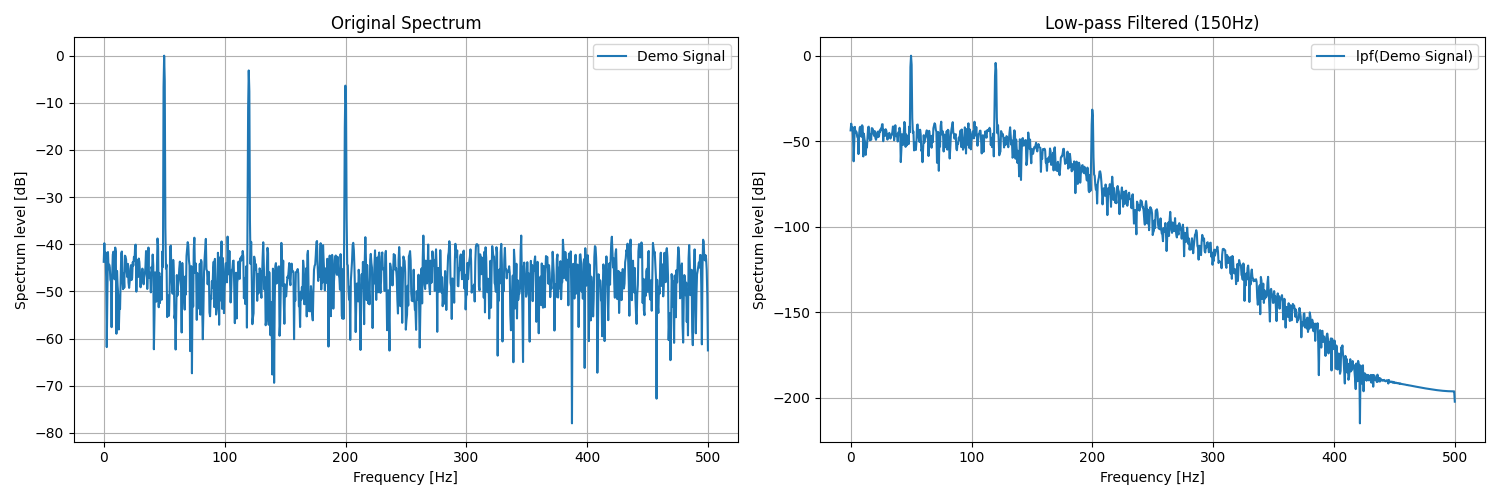

In [7]:
# ローパスフィルタ適用（150Hzカットオフ）
lowpass_filtered = demo_signal.low_pass_filter(cutoff=150)

print("🎛️ ローパスフィルタ適用:")
print(f"  カットオフ: 150 Hz")
print(f"  元信号RMS: {demo_signal.rms[0]:.4f}")
print(f"  フィルタ後RMS: {lowpass_filtered.rms[0]:.4f}")

# フィルタ前後のスペクトル比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

demo_signal.fft().plot(ax=ax1, title="Original Spectrum")
lowpass_filtered.fft().plot(ax=ax2, title="Low-pass Filtered (150Hz)")

plt.tight_layout()
plt.show()

**📉 ローパスフィルタの効果**

- **200Hz成分**が大幅に減衰
- **50Hzと120Hz**はほぼ変化なし
- **ノイズ**も一部除去されている

### ハイパスフィルタ

**低周波成分（オフセットなど）を除去**します。

🎛️ ハイパスフィルタ適用:
  カットオフ: 30 Hz
  オフセット付きRMS: 2.2121
  フィルタ後RMS: 0.9275


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


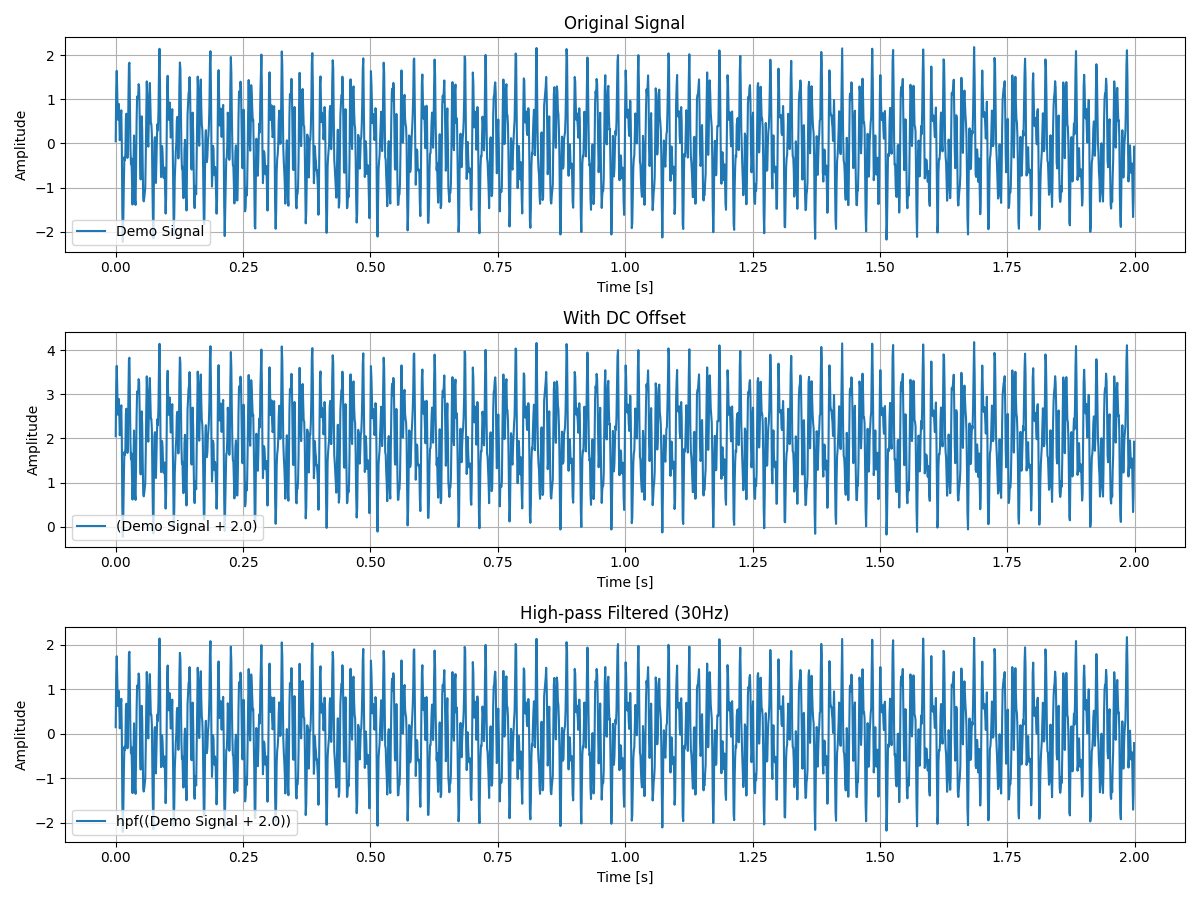

In [8]:
# オフセットを追加した信号を作成
signal_with_offset = demo_signal + 2.0  # DCオフセット

# ハイパスフィルタ適用（30Hzカットオフ）
highpass_filtered = signal_with_offset.high_pass_filter(cutoff=30)

print("🎛️ ハイパスフィルタ適用:")
print(f"  カットオフ: 30 Hz")
print(f"  オフセット付きRMS: {signal_with_offset.rms[0]:.4f}")
print(f"  フィルタ後RMS: {highpass_filtered.rms[0]:.4f}")

# 時間領域での比較
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

demo_signal.plot(ax=ax1, title="Original Signal")
signal_with_offset.plot(ax=ax2, title="With DC Offset")
highpass_filtered.plot(ax=ax3, title="High-pass Filtered (30Hz)")

plt.tight_layout()
plt.show()

**📈 ハイパスフィルタの効果**

- **DCオフセット**が除去されて0付近に戻る
- **低周波成分**が減衰
- **高周波成分**は保持される

### バンドパスフィルタ

**特定の周波数帯域のみを通す**フィルタです。

🎛️ バンドパスフィルタ適用:
  通過帯域: 80 - 160 Hz
  中心周波数: 120 Hz
  元信号RMS: 0.9356
  フィルタ後RMS: 0.4979


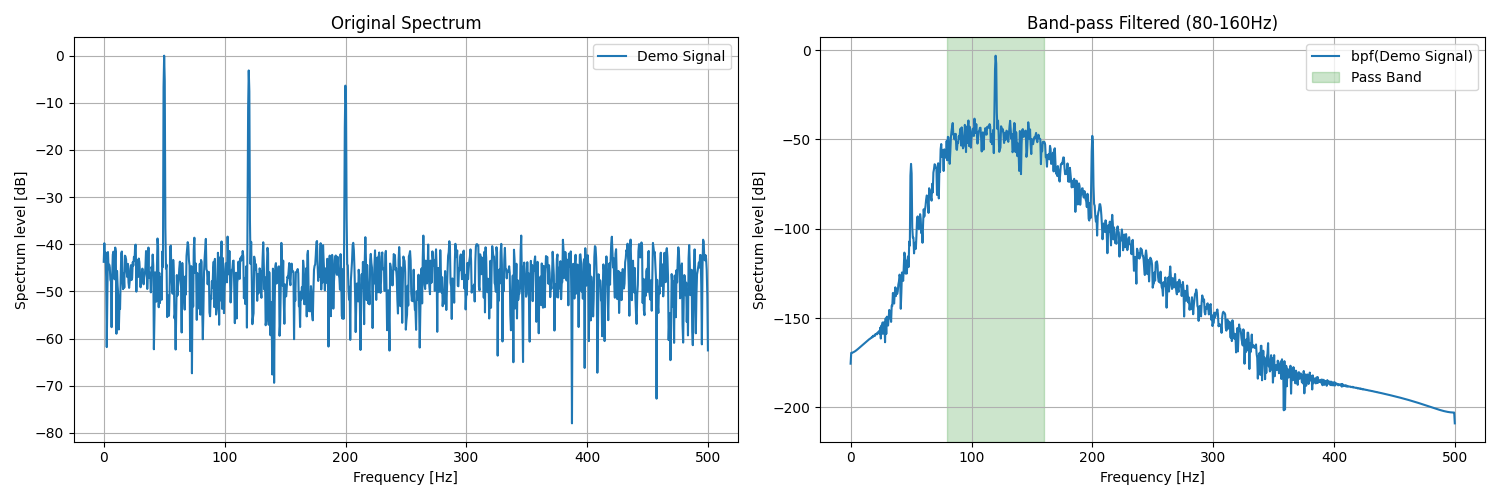

In [9]:
# バンドパスフィルタ（80-160Hz）
bandpass_filtered = demo_signal.band_pass_filter(low_cutoff=80, high_cutoff=160)

print("🎛️ バンドパスフィルタ適用:")
print(f"  通過帯域: 80 - 160 Hz")
print(f"  中心周波数: 120 Hz")
print(f"  元信号RMS: {demo_signal.rms[0]:.4f}")
print(f"  フィルタ後RMS: {bandpass_filtered.rms[0]:.4f}")

# スペクトル比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

demo_signal.fft().plot(ax=ax1, title="Original Spectrum")
bandpass_filtered.fft().plot(ax=ax2, title="Band-pass Filtered (80-160Hz)")

# 通過帯域をハイライト
ax2.axvspan(80, 160, alpha=0.2, color='green', label='Pass Band')
ax2.legend()

plt.tight_layout()
plt.show()

**🎯 バンドパスフィルタの効果**

- **120Hz成分**のみが残る
- **50Hzと200Hz**は大幅に減衰
- **ノイズ**も帯域外で除去

## 🔧 フィルタパラメータの調整

### フィルタ次数の影響

フィルタ次数を変更すると**遮断特性**が変わります。

🔧 フィルタ次数の比較:
  Order 2: RMS = 0.6859
  Order 4: RMS = 0.7087
  Order 8: RMS = 0.7062


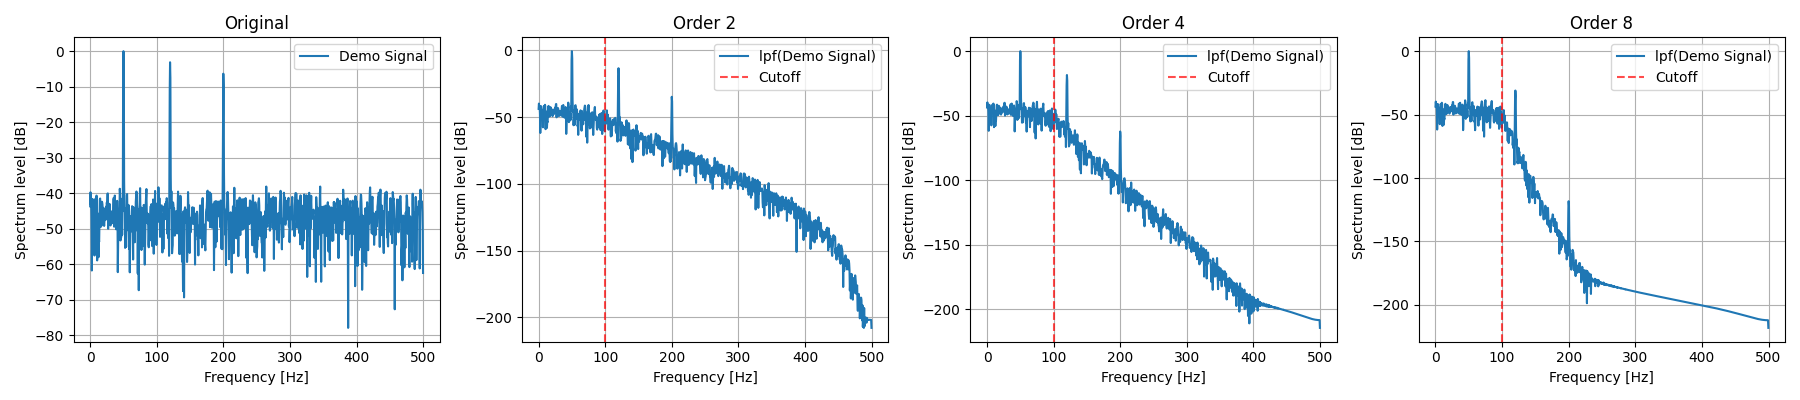

In [10]:
# 異なる次数のローパスフィルタを比較
orders = [2, 4, 8]
filtered_signals = {}

for order in orders:
    filtered = demo_signal.low_pass_filter(cutoff=100, order=order)
    filtered_signals[f'Order {order}'] = filtered

print("🔧 フィルタ次数の比較:")
for name, signal in filtered_signals.items():
    print(f"  {name}: RMS = {signal.rms[0]:.4f}")

# スペクトル比較
fig, axes = plt.subplots(1, len(orders) + 1, figsize=(18, 4))

# 元信号
demo_signal.fft().plot(ax=axes[0], title="Original")

# フィルタ適用後
for i, (name, signal) in enumerate(filtered_signals.items(), 1):
    signal.fft().plot(ax=axes[i], title=name)
    axes[i].axvline(100, color='red', linestyle='--', alpha=0.7, label='Cutoff')
    axes[i].legend()

plt.tight_layout()
plt.show()

**⚙️ フィルタ次数の影響**

- **次数が低い**（Order 2）: 遮断が緩やか
- **次数が高い**（Order 8）: 遮断が急峻
- **次数が高いほど**計算コストが増大

## 🎨 スペクトログラム分析

### 時間-周波数分析

**スペクトログラム**は信号の**時間変化する周波数特性**を表示します：
- **X軸**: 時間
- **Y軸**: 周波数
- **色**: 振幅（強度）
- **時間分解能 vs 周波数分解能**のトレードオフ

In [11]:
# 時間変化する信号を作成
time_varying_signal = np.zeros_like(time)

# 前半: 50Hz + 100Hz
mask1 = time < 1.0
time_varying_signal[mask1] = (
    1.0 * np.sin(2 * np.pi * 50 * time[mask1]) +
    0.8 * np.sin(2 * np.pi * 100 * time[mask1])
)

# 後半: 150Hz + 200Hz
mask2 = time >= 1.0
time_varying_signal[mask2] = (
    1.0 * np.sin(2 * np.pi * 150 * time[mask2]) +
    0.8 * np.sin(2 * np.pi * 200 * time[mask2])
)

# ChannelFrame作成
tv_signal = wd.from_numpy(
    data=time_varying_signal.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Time-Varying Signal']
)

print(f"時間変化信号作成: {tv_signal.shape}")

時間変化信号作成: (2000,)


📊 スペクトログラム分析:
SpectrogramFrame Information:
  Channels: 1
  Sampling rate: 1000 Hz
  FFT size: 256
  Hop length: 128 samples
  Window length: 256 samples
  Window: hann
  Frequency range: 0.0 - 500.0 Hz
  Frequency bins: 129
  Frequency resolution (ΔF): 3.9 Hz
  Time frames: 17
  Time resolution (ΔT): 128.0 ms
  Total duration: 2.18 s
  Channel labels: ['Time-Varying Signal']
  Operations Applied: None


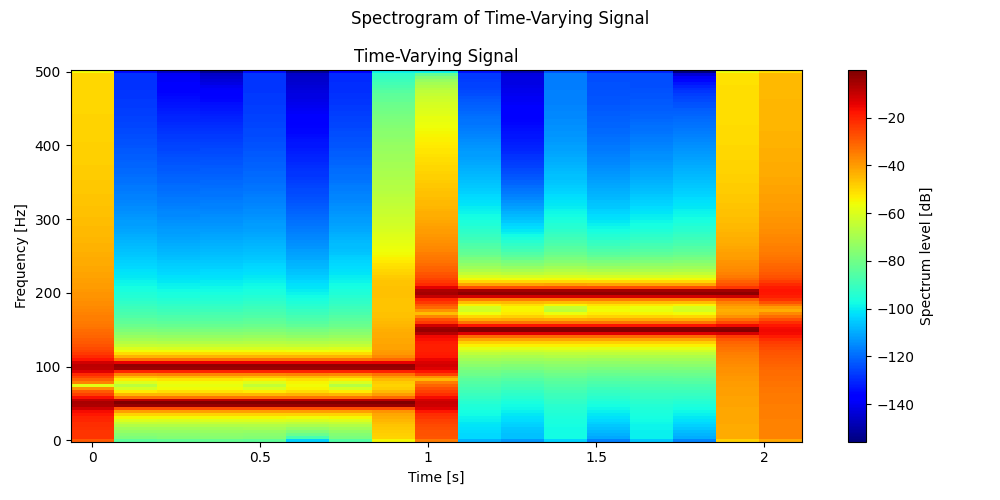

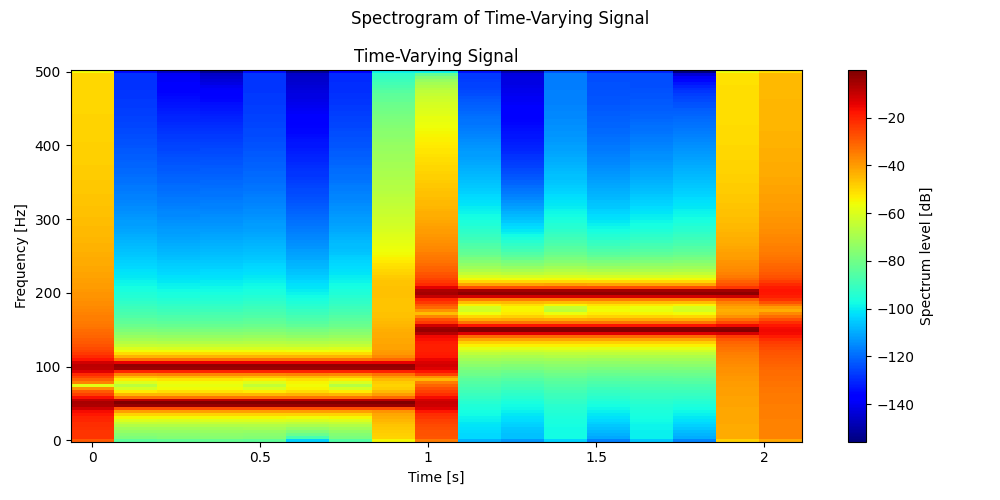

In [12]:
# スペクトログラムを計算
spectrogram = tv_signal.stft(
    n_fft=256,      # FFTサイズ
    hop_length=128, # ホップサイズ
    window='hann'   # 窓関数
)

print("📊 スペクトログラム分析:")
spectrogram.info()

# スペクトログラムを表示
spectrogram.plot(title="Spectrogram of Time-Varying Signal")
plt.show()

**🌈 スペクトログラムの読み方**

- **前半（0-1秒）**: 50Hzと100Hzの成分
- **後半（1-2秒）**: 150Hzと200Hzの成分
- **色が明るいほど**: 振幅が大きい
- **縦線**: 特定の周波数成分
- **横線**: 時間的な変化

## 🚀 実践的な信号処理ワークフロー


### 現実的な分析例




センサーデータを対象にした**保全診断フロー**を体験しましょう。

以下の4ステップで、測定された振動データを読み解きます。



1. **観察する**: 時間・周波数の両面から現状を把握

2. **整える**: DCオフセットやドリフト、広帯域ノイズを除去

3. **焦点を当てる**: 故障徴候が現れやすい周波数帯を抽出

4. **特徴を取り出す**: 指標化（RMSトレンド・スペクトログラム）で変化を定量化

振動データ作成: (10000,), 2000 Hz


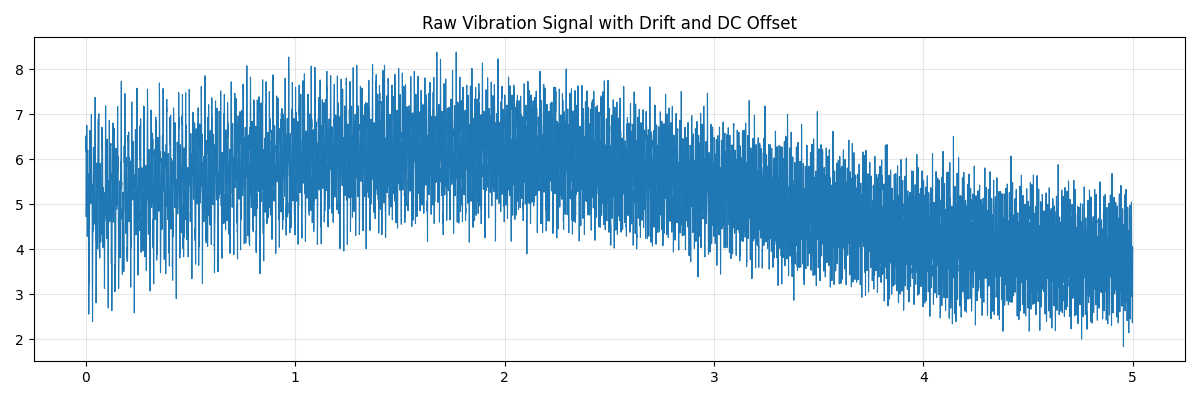

In [13]:
# 現実的なセンサーデータを作成（振動分析風）
np.random.seed(123)
sensor_sr = 2000  # 2kHz
sensor_duration = 5.0
sensor_time = np.linspace(0, sensor_duration, int(sensor_duration * sensor_sr))


# 顕著なDC成分と漂遊ドリフト + 電源ハム + 高周波ノイズ
drift_component = (
    1.2 * np.sin(2 * np.pi * 0.15 * sensor_time) +      # ゆっくりとしたドリフト
    0.0025 * sensor_time                                # 緩やかな直線ドリフト
 )


vibration_signal = (
    drift_component +
    1.0 * np.sin(2 * np.pi * 55 * sensor_time) * np.exp(-sensor_time / 2) +  # 徐々に減衰する55Hz成分
    0.9 * np.sin(2 * np.pi * 120 * sensor_time) +           # 主モード
    0.5 * np.sin(2 * np.pi * 280 * sensor_time) +           # 高周波成分
    0.25 * np.random.randn(len(sensor_time))                # 広帯域ノイズ
 )


# DCオフセットを追加
vibration_signal += 5.0


# ChannelFrame作成
vibration_data = wd.from_numpy(
    data=vibration_signal.reshape(1, -1),
    sampling_rate=sensor_sr,
    ch_labels=['Vibration Sensor']
 )


print(f"振動データ作成: {vibration_data.shape}, {vibration_data.sampling_rate} Hz")


fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(sensor_time, vibration_signal, color="#1f77b4", linewidth=0.8)
ax.set_title("Raw Vibration Signal with Drift and DC Offset")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🚀 振動データ分析ワークフロー (保全診断フロー):
1. 📊 生データ観察
   Duration: 5.0 s, RMS: 5.3904
   Snapshot mean: 5.2638

2. 🔧 前処理
   - remove_dc → high_pass_filter(20 Hz) でドリフトを除去
   - low_pass_filter(250 Hz) で広帯域ノイズを抑制

3. 🎯 周波数帯域にフォーカス
   監視帯域: 80 - 180 Hz

4. 📈 主要成分の確認 (Magnitude 上位3ピーク)
   Raw: 0.0 Hz
   Denoised: 0.0 Hz
   Band-focused: 0.0 Hz

   RMSトレンド統計 (band-focused)
   mean=0.4566, max=0.4566, std=0.0000


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


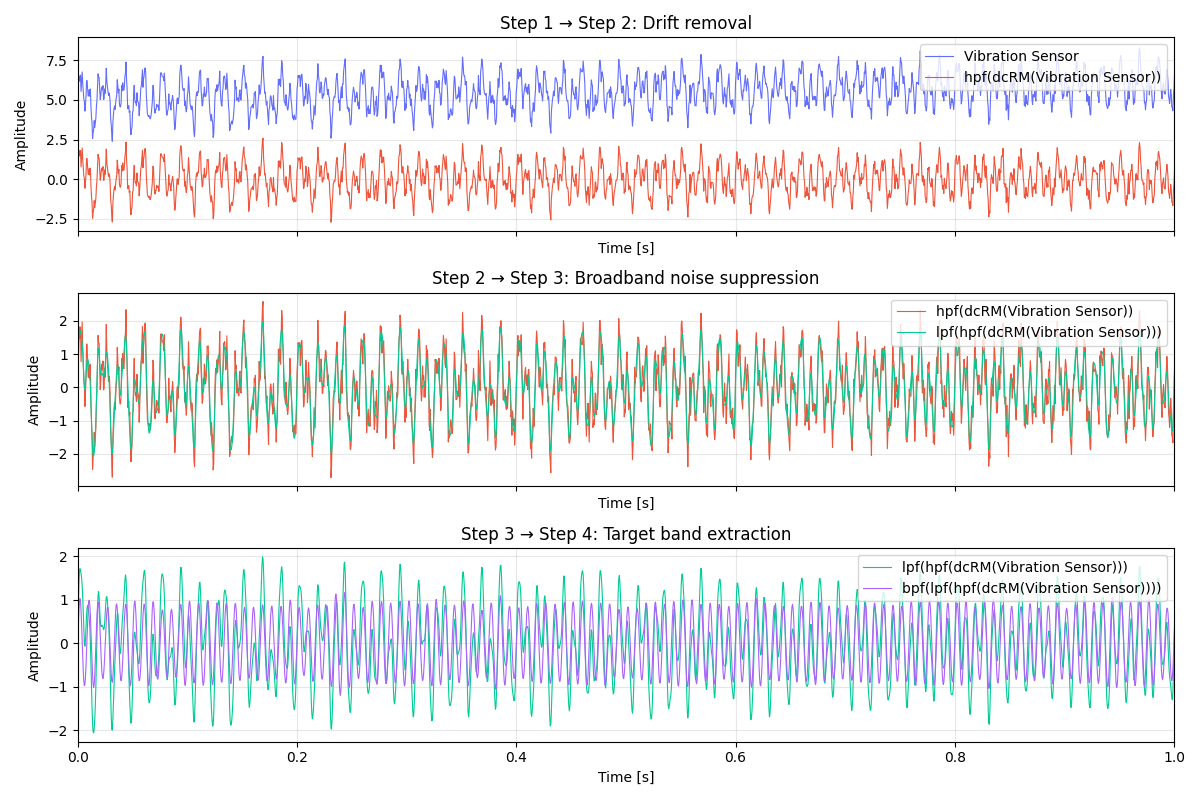

In [14]:
# 完全な信号処理ワークフロー
print("🚀 振動データ分析ワークフロー (保全診断フロー):")


target_band = (80.0, 180.0)  # 故障兆候を重点監視したい帯域


# 1. 観察する
print("1. 📊 生データ観察")
print(f"   Duration: {vibration_data.duration:.1f} s, RMS: {vibration_data.rms[0]:.4f}")
print(f"   Snapshot mean: {float(vibration_data.data.mean()):.4f}")


# 2. 整える（DC除去 + ドリフト抑制 + 広帯域ノイズ低減）
cleaned = vibration_data.remove_dc().high_pass_filter(cutoff=20)
denoised = cleaned.low_pass_filter(cutoff=250)
print("\n2. 🔧 前処理")
print("   - remove_dc → high_pass_filter(20 Hz) でドリフトを除去")
print("   - low_pass_filter(250 Hz) で広帯域ノイズを抑制")


# 3. 焦点を当てる（関心帯域の抽出）
focused = denoised.band_pass_filter(low_cutoff=target_band[0], high_cutoff=target_band[1])
print("\n3. 🎯 周波数帯域にフォーカス")
print(f"   監視帯域: {target_band[0]:.0f} - {target_band[1]:.0f} Hz")


# 4. 特徴を取り出す
spectral_raw = vibration_data.welch()
spectral_denoised = denoised.welch()
spectral_focused = focused.welch()


trend = focused.rms_trend(frame_length=1024, hop_length=256)
trend_values = np.asarray(trend.data)[0]
spectrogram = focused.stft(n_fft=512, hop_length=256)


def summarize_peaks(label: str, spectrum: "SpectralFrame") -> None:
    freqs = np.asarray(spectrum.freqs)
    magnitudes = np.abs(np.asarray(spectrum.data[0]))
    top_indices = np.argsort(magnitudes)[-3:][::-1]
    summary = ", ".join(f"{freqs[i]:.1f} Hz" for i in top_indices)
    print(f"   {label}: {summary}")


print("\n4. 📈 主要成分の確認 (Magnitude 上位3ピーク)")
summarize_peaks("Raw", spectral_raw)
summarize_peaks("Denoised", spectral_denoised)
summarize_peaks("Band-focused", spectral_focused)


print("\n   RMSトレンド統計 (band-focused)")
print(f"   mean={trend_values.mean():.4f}, max={trend_values.max():.4f}, std={trend_values.std():.4f}")


# 1秒間の変化を図示して各ステップの効果を視覚化
time_np = np.asarray(vibration_data.time)
window = time_np <= 1.0

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Step 1 → Step 2: Drift removal
vibration_data.plot(ax=axes[0], label="Raw", color="#636efa", linewidth=0.8)
cleaned.plot(ax=axes[0], label="remove_dc + high_pass", color="#ef553b", linewidth=0.8)
axes[0].set_title("Step 1 → Step 2: Drift removal")
axes[0].legend(loc="upper right")
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(time_np[0], 1.0)  # 1秒間に制限

# Step 2 → Step 3: Broadband noise suppression
cleaned.plot(ax=axes[1], label="After high-pass", color="#ef553b", linewidth=0.8)
denoised.plot(ax=axes[1], label="After low-pass", color="#00cc96", linewidth=0.8)
axes[1].set_title("Step 2 → Step 3: Broadband noise suppression")
axes[1].legend(loc="upper right")
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(time_np[0], 1.0)

# Step 3 → Step 4: Target band extraction
denoised.plot(ax=axes[2], label="Before band-pass", color="#00cc96", linewidth=0.8)
focused.plot(ax=axes[2], label="Band-focused", color="#ab63fa", linewidth=0.8)
axes[2].set_title("Step 3 → Step 4: Target band extraction")
axes[2].set_xlabel("Time [s]")
axes[2].legend(loc="upper right")
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(time_np[0], 1.0)

plt.tight_layout()
plt.show()



5. 🖼️ 可視化での比較


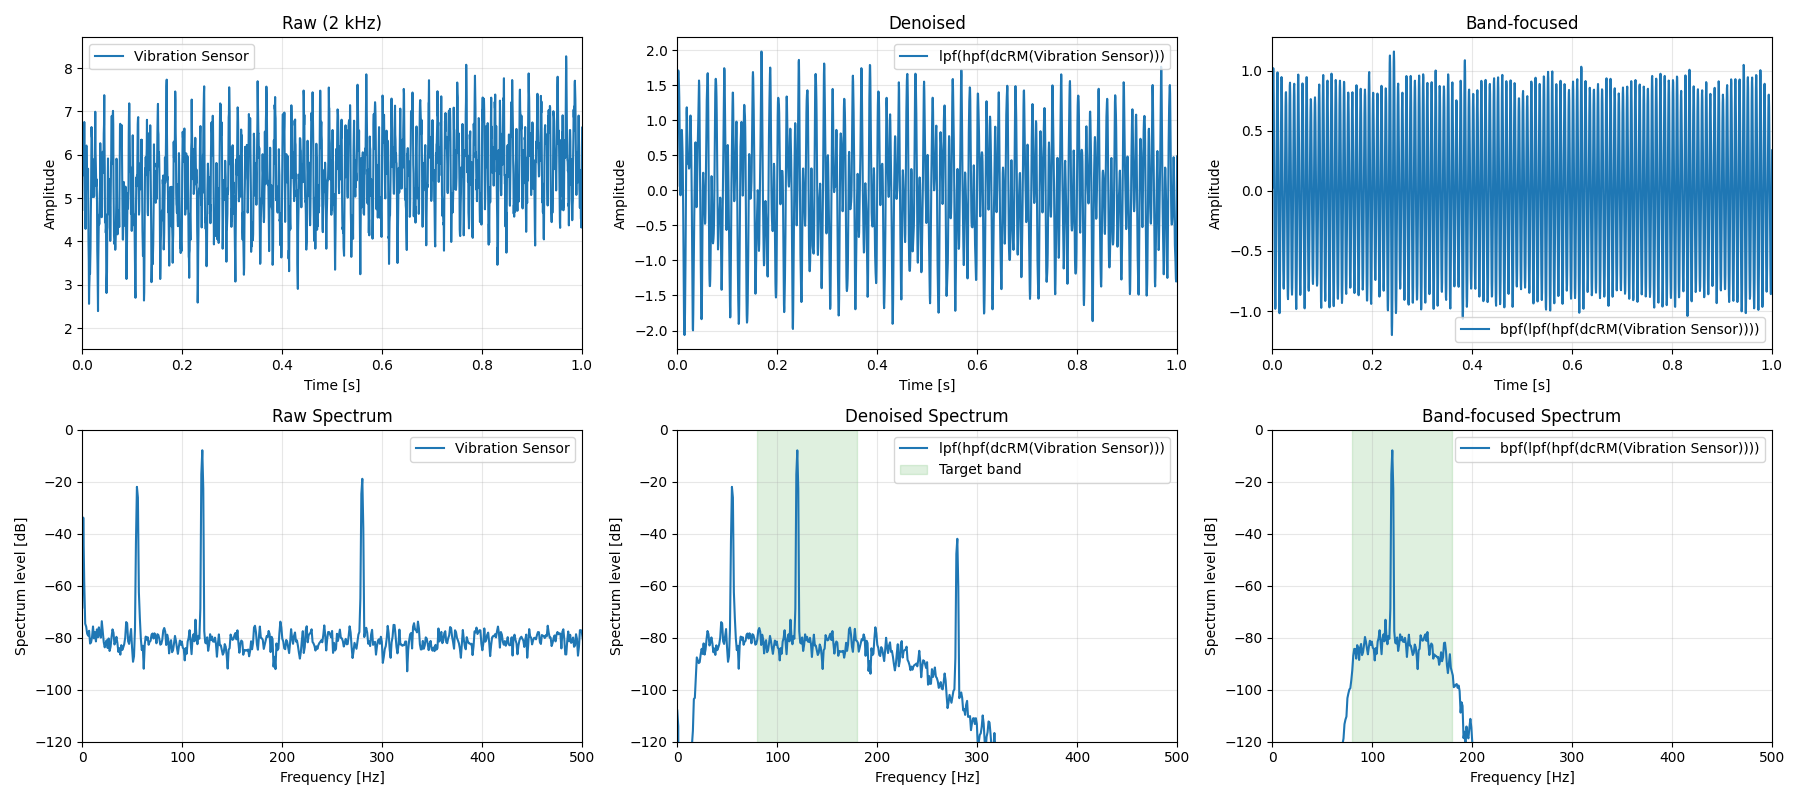

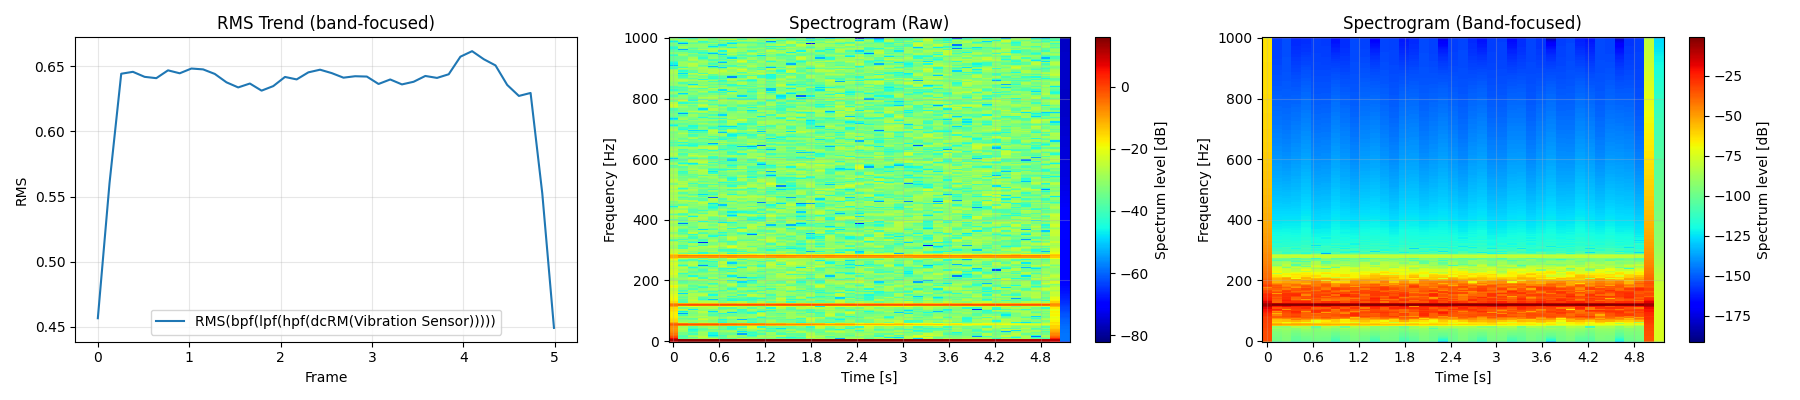


✅ クリーニングと帯域抽出により、観測したい周波数成分が明瞭になり、トレンド指標・時間周波数解析で状態監視の準備が整いました。


In [15]:
# 5. 可視化で比較
print("\n5. 🖼️ 可視化での比較")
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

vibration_data.plot(ax=axes[0, 0], title="Raw (2 kHz)", xlim=(0, 1.0))
denoised.plot(ax=axes[0, 1], title="Denoised", xlim=(0, 1.0))
focused.plot(ax=axes[0, 2], title="Band-focused", xlim=(0, 1.0))

spectral_raw.plot(ax=axes[1, 0], title="Raw Spectrum", xlim=(0, 500), ylim=(-120, 0))
spectral_denoised.plot(ax=axes[1, 1], title="Denoised Spectrum", xlim=(0, 500), ylim=(-120, 0))
spectral_focused.plot(ax=axes[1, 2], title="Band-focused Spectrum", xlim=(0, 500), ylim=(-120, 0))

axes[1, 1].axvspan(target_band[0], target_band[1], alpha=0.15, color="tab:green", label="Target band")
axes[1, 2].axvspan(target_band[0], target_band[1], alpha=0.15, color="tab:green")
axes[1, 1].legend(loc="upper right")

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 元の信号のスペクトログラムを追加
spectrogram_raw = vibration_data.stft(n_fft=512, hop_length=256)

fig, (ax_trend, ax_spec_raw, ax_spec_focused) = plt.subplots(1, 3, figsize=(18, 4))
trend.plot(ax=ax_trend, title="RMS Trend (band-focused)", xlabel="Frame", ylabel="RMS")
spectrogram_raw.plot(ax=ax_spec_raw, title="Spectrogram (Raw)")
spectrogram.plot(ax=ax_spec_focused, title="Spectrogram (Band-focused)")

for ax in (ax_trend, ax_spec_raw, ax_spec_focused):
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ クリーニングと帯域抽出により、観測したい周波数成分が明瞭になり、トレンド指標・時間周波数解析で状態監視の準備が整いました。")


### 🔍 結果の読み解き


- `remove_dc` と `high_pass_filter(20 Hz)` により大きなDCバイアスと緩やかなドリフトが除去され、ゼロ基準で比較しやすくなる。

- `low_pass_filter(250 Hz)` により広帯域ノイズが抑制され、主成分（120 Hz 付近）が浮かび上がる。

- ターゲット帯域 (80–180 Hz) を `band_pass_filter` で抽出すると、故障兆候に関連する周波数だけを継続監視できる。

- RMSトレンドで振幅変動を定量化し、スペクトログラムで55 Hz成分が減衰していく様子を時間とともに確認できる。

## 🛠️ トラブルシューティング

### よくある信号処理の問題

#### 1. エイリアシング（折り返し歪み）
- **原因**: サンプリング周波数が不十分
- **対策**: ローパスフィルタで事前フィルタリング
- **目安**: カットオフ < サンプリング周波数の1/2

#### 2. フィルタのリンギング
- **原因**: 高次フィルタの位相特性
- **対策**: 次数を下げるか、線形位相フィルタを使用

#### 3. スペクトルの漏れ
- **原因**: 非整数周期の信号
- **対策**: 窓関数を使用、FFTサイズを調整

#### 4. ノイズの影響
- **原因**: 測定環境やセンサーの特性
- **対策**: アベレージング、フィルタリング、適切なセンサー選択

## 📚 次のステップ

信号処理の基礎をマスターしました！

**次のノートブック**: [04_advanced_processing.ipynb](04_advanced_processing.ipynb)

ここでは、**スペクトル分析**や**ウェーブレット変換**などの高度な信号処理手法を紹介します。

### 🎯 これまでに学んだこと
- ✅ FFTによる周波数領域変換
- ✅ ローパス/ハイパス/バンドパスフィルタ
- ✅ フィルタパラメータの調整（次数、遮断周波数）
- ✅ スペクトログラムによる時間-周波数分析
- ✅ 完全な信号処理ワークフローの実践

### 🚀 次の学習目標
- ウェーブレット変換
- スペクトル分析の高度な手法
- 信号の統計的特性分析
- 機械学習との統合

---

**信号処理の基礎を身につけました。高度な分析の世界へ！** 🔬